# 4. Earthquake Damage in Kavrepalanchok 🇳🇵

In this assignment, you'll build a classification model to predict building damage for the district of [Kavrepalanchok](https://en.wikipedia.org/wiki/Kavrepalanchok_District).

In [95]:
# Import libraries here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap, boxplot

import sqlite3

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Prepare Dataheatmap

## Connect

Run the cell below to connect to the `nepal.sqlite` database.<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

In [3]:
%load_ext sql
%sql sqlite:////home/jovyan/nepal.sqlite

'Connected: @/home/jovyan/nepal.sqlite'

<div class="alert alert-block alert-warning">
<b>Warning:</b>Be careful with your SQL queries in this assignment. If you try to get all the rows from a table (for example, <code>SELECT * FROM id_map</code>), you will cause an Out of Memory error on your virtual machine. So always include a <code>LIMIT</code> when first exploring a database.
</div>

**Task 4.5.1:** What districts are represented in the `id_map` table? Determine the unique values in the **`district_id`** column.

In [6]:
%%sql

SELECT name
FROM sqlite_schema
WHERE type = "table"

 * sqlite:////home/jovyan/nepal.sqlite
Done.


name
id_map
building_structure
building_damage
household_demographics


In [158]:
%%sql

SELECT DISTINCT district_id 
FROM id_map

 * sqlite:////home/jovyan/nepal.sqlite
Done.


district_id
1
2
3
4


What's the district ID for Kavrepalanchok? From the lessons, you already know that Gorkha is `4`; from the textbook, you know that Ramechhap is `2`. Of the remaining districts, Kavrepalanchok is the one with the largest number of observations in the `id_map` table.

**Task 4.5.2:** Calculate the number of observations in the `id_map` table associated with district `1`.

In [17]:
%%sql

SELECT district_id, COUNT(*) AS count
FROM id_map
GROUP BY district_id
ORDER BY count

 * sqlite:////home/jovyan/nepal.sqlite
Done.


district_id,count
1,36112
2,55253
4,75883
3,82684


In [14]:
%%sql

SELECT COUNT(district_id) AS count
FROM id_map
WHERE district_id = 1

 * sqlite:////home/jovyan/nepal.sqlite
Done.


count
36112


**Task 4.5.3:** Calculate the number of observations in the `id_map` table associated with district `3`.

In [18]:
%%sql

SELECT COUNT(district_id) AS count
FROM id_map
WHERE district_id = 3

 * sqlite:////home/jovyan/nepal.sqlite
Done.


count
82684


**Task 4.5.4:** Join the unique building IDs from Kavrepalanchok in `id_map`, all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`, limiting. Make sure you rename the **`building_id`** column in `id_map` as **`b_id`** and limit your results to the first five rows of the new table.

In [27]:
%%sql

SELECT 
    DISTINCT i.building_id AS b_id,
    s.*,
    d.damage_grade
FROM id_map AS i
    JOIN building_structure AS s
        ON i.building_id = s.building_id
    JOIN building_damage AS d
        ON i.building_id = d.building_id
WHERE 
    i.district_id = 3
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


## Import

**Task 4.5.5:** Write a `wrangle` function that will use the query you created in the previous task to create a DataFrame. In addition your function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in your model.

In [89]:
# Build your `wrangle` function here
def wrangle(path):
    conn = sqlite3.connect(path)
    
    query = """
            SELECT 
                DISTINCT i.building_id AS b_id,
                s.*,
                d.damage_grade
            FROM id_map AS i
                JOIN building_structure AS s
                    ON i.building_id = s.building_id
                JOIN building_damage AS d
                    ON i.building_id = d.building_id
            WHERE 
                i.district_id = 3
            """
    
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Encode damage grade
    df["severe_damage"] = (df["damage_grade"].str[-1] > "3").astype("int")
    
    drop_columns = ["building_id", "damage_grade"]
    
    # Add the leaky columns to drop list
    drop_columns.extend(df.columns[df.columns.str.contains("post_eq")])
    
    # Add the multicollinear columns to the drop list
    drop_columns.append("count_floors_pre_eq")
    
    df.drop(columns=drop_columns, inplace=True)
    
    return df

Use your `wrangle` function to query the database at `"/home/jovyan/nepal.sqlite"` and return  your cleaned results.

In [90]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


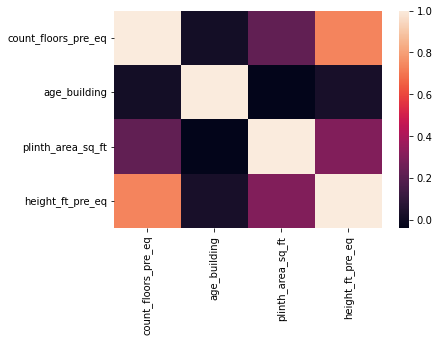

In [87]:
heatmap(df.select_dtypes(include="number").drop(columns="severe_damage").corr());

In [88]:
df.loc[:,["count_floors_pre_eq", "height_ft_pre_eq", "severe_damage"]].corr()

,count_floors_pre_eq,height_ft_pre_eq,severe_damage
count_floors_pre_eq,1.000000,0.734526,-0.035180
height_ft_pre_eq,0.734526,1.000000,-0.158044
severe_damage,-0.035180,-0.158044,1.000000


## Explore

**Task 4.5.6:** Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column. Be sure to label the x-axis `"Severe Damage"` and the y-axis `"Relative Frequency"`. Use the title `"Kavrepalanchok, Class Balance"`.

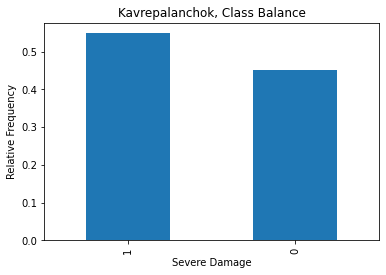

In [92]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", 
    xlabel="Severe Damage", 
    ylabel="Relative Frequency", 
    title="Kavrepalanchok, Class Balance"
)
# Don't delete the code below 👇
plt.savefig("images/4-5-6.png", dpi=150)


**Task 4.5.7:** Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? Use seaborn to create a boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column. Label your x-axis `"Severe Damage"` and y-axis `"Plinth Area [sq. ft.]"`. Use the title `"Kavrepalanchok, Plinth Area vs Building Damage"`. 

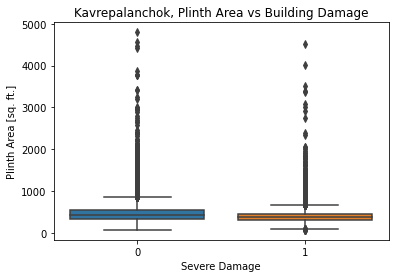

In [99]:
boxplot(data=df, x="severe_damage", y="plinth_area_sq_ft")
plt.xlabel("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage")
# Don't delete the code below 👇
plt.savefig("images/4-5-7.png", dpi=150)


**Task 4.5.8:** Are buildings with certain roof types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [101]:
roof_pivot = df.pivot_table(index="roof_type", values="severe_damage", aggfunc=np.mean)
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842
RCC/RB/RBC,0.040715


## Split

**Task 4.5.9:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [103]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


**Task 4.5.10:** Divide your dataset into training and validation sets using a randomized split. Your validation set should be 20% of your data.

In [107]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

**Task 4.5.11:** Calculate the baseline accuracy score for your model.

In [109]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

**Task 4.5.12:** Create a model `model_lr` that uses logistic regression to predict building damage. Be sure to include an appropriate encoder for categorical features. 

In [113]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

**Task 4.5.13:** Calculate training and validation accuracy score for `model_lr`. 

In [114]:
lr_train_acc = accuracy_score(y_train, model_lr.predict(X_train))
lr_val_acc = accuracy_score(y_val, model_lr.predict(X_val))

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6513735994512135
Logistic Regression, Validation Accuracy Score: 0.6530998889397008


**Task 4.5.14:** Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_dt` at all depths from 1 to 15. Be sure to use an appropriate encoder for your model, and to record its training and validation accuracy scores at every depth. The grader will evaluate your validation accuracy scores only.

In [143]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(
            max_depth=d, 
            random_state=42
        )
    )
    
    model_dt.fit(X_train, y_train)
    
    training_acc.append(accuracy_score(y_train, model_dt.predict(X_train)))
    validation_acc.append(accuracy_score(y_val, model_dt.predict(X_val)))

**Task 4.5.15:** Using the values in `training_acc` and `validation_acc`, plot the validation curve for `model_dt`. Label your x-axis `"Max Depth"` and your y-axis `"Accuracy Score"`. Use the title `"Validation Curve, Decision Tree Model"`, and include a legend. 

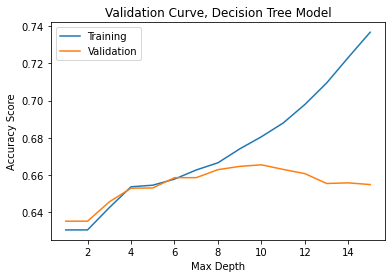

In [145]:
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model")
plt.legend()
# Don't delete the code below 👇
plt.savefig("images/4-5-15.png", dpi=150)


**Task 4.5.16:** Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [150]:
final_model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=10, random_state=42)
)

final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
RC, engineered           4
Brick, mud mortar        5
Stone, cement mortar     6
RC, non-engineered       7
Timber                   8
Other                    9
Bamboo                  10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

## Evaluate

**Task 4.5.17:** How does your model perform on the test set? First, read the CSV file `"data/kavrepalanchok-test-features.csv"` into the DataFrame `X_test`. Next, use `final_model_dt` to generate a list of test predictions `y_test_pred`. Finally, submit your test predictions to the grader to see how your model performs.

**Tip:** Make sure the order of the columns in `X_test` is the same as in your `X_train`. Otherwise, it could hurt your model's performance.

In [152]:
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

array([1, 1, 1, 1, 0])

# Communicate Results

**Task 4.5.18:** What are the most important features for `final_model_dt`? Create a Series Gini `feat_imp`, where the index labels are the feature names for your dataset and the values are the feature importances for your model. Be sure that the Series is sorted from smallest to largest feature importance. 

In [163]:
feat_imp = pd.Series(
    index = X_train.columns,
    data = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_
).sort_values(ascending=True)
feat_imp.head()

plan_configuration        0.004189
land_surface_condition    0.008599
foundation_type           0.009967
position                  0.011795
ground_floor_type         0.013521
dtype: float64

**Task 4.5.19:** Create a horizontal bar chart of `feat_imp`. Label your x-axis `"Gini Importance"` and your y-axis `"Label"`. Use the title `"Kavrepalanchok Decision Tree, Feature Importance"`.

Do you see any relationship between this plot and the exploratory data analysis you did regarding roof type?

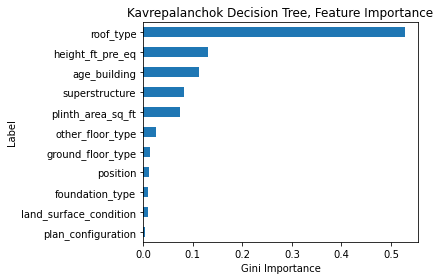

In [164]:
# Create horizontal bar chart of feature importances
feat_imp.plot(
    kind="barh", 
    xlabel="Gini Importance", 
    ylabel="Label",
    title="Kavrepalanchok Decision Tree, Feature Importance"
)
# Don't delete the code below 👇
plt.tight_layout()
plt.savefig("images/4-5-19.png", dpi=150)


Congratulations! You made it to the end of Project 4. 👏👏👏